In [161]:
%pylab inline 

import json
import pandas as pd
import nltk
import numpy as np
import random
import re
import string
import progressbar

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn import cross_validation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import seaborn as sns
import statsmodels.formula.api as smf

from collections import Counter, OrderedDict

from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import word_tokenize

from scipy.sparse import hstack
from afinn import Afinn

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedLineDocument
from gensim.models.doc2vec import LabeledSentence
from gensim import models

import time
import afinn

Populating the interactive namespace from numpy and matplotlib


/Users/shraws/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hstack', 'random', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
REVIEWS = 'reviews'
stemmer = PorterStemmer()

In [167]:
category_map = {
    #"Amazon_Instant_Video" : 0
   # "Apps_for_Android" : 1,
   # "Automotive" : 2,
   # "Baby" : 3,
   # "Beauty" : 4,
   # "Books" : 5,
#     "CDs_and_Vinyl" : 6,
#     "Cell_Phones_and_Accessories" : 7,
   #  "Clothing_Shoes_and_Jewelry" : 8,
    #"Digital_Music" : 9
  #    "Electronics" : 10
  #   "Grocery_and_Gourmet_Food" : 11
#     "Health_and_Personal_Care" : 12,
#     "Home_and_Kitchen" : 13,
#     "Kindle_Store" : 14,
#     "Movies_and_TV" : 15,
   #  "Musical_Instruments" : 16,
     "Office_Products" : 17
#     "Patio_Lawn_and_Garden" : 18,
   #  "Pet_Supplies" : 19
#     "Sports_and_Outdoors" : 20,
#     "Tools_and_Home_Improvement" : 21,
#     "Toys_and_Games" : 22,
#     "Video_Games" : 23
}

col_names = ["reviewer_id", "asin", "summary","review_text", "overall", "category", "total_votes","upvotes","score",
             "good", "bad"]

In [33]:
def read_dataset(category_t):
    data =[]
    for category in category_map:
        if category_map[category] == category_t:
            fn = "data/" + REVIEWS+ "_" + category + "_"+"5" + ".json"
            print("Reading category", category)
            with open(fn) as f:
                for line in f:
                    d = json.loads(line)
                    pf, tf = d["helpful"]
                    if tf >1 and len(d["reviewText"].split())  >10:
                        score = int(pf) / int(tf)
                        row = [d["reviewerID"], 
                               d["asin"], 
                               d["summary"],
                               d["reviewText"],
                               d["overall"],
                               category_map[category],
                               int(tf),
                               int(pf),
                               (score),
                               int(score >= 0.80),
                               int(score <= 0.20)]
                        data.append(row)
    print("File read!")
    return pd.DataFrame(data, columns=col_names)

In [34]:
#Calculates fraction of unique words
def text_richness(text):
    return len(set(text.split()))/len(text.split())


In [45]:
def process_text(text, stem_in = True):
    # lowercase
    # remove symbols
    RE_PREPROCESS = r'\W+|\d+'  
#get rid of punctuation and make everything lowercase
    text = re.sub(RE_PREPROCESS, ' ', text).lower()
    if stem_in:
        return stemmer.stem(text)
    return text

def total_characters(fd):
    sum = 0
    for v,k in fd.items():
        sum += (v*k)
    return sum

def word_length_avg(text):
    fd = nltk.FreqDist(len(w) for w in process_text(text).split())
    print(fd)
    if fd.N() ==0:
        print("issue detected: ", text)
    return total_characters(fd)/fd.N()

In [36]:

def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [37]:

def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                       stem = False,
                       MIN_DF = 0.02,
                       MAX_DF = 0.8,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tupule
        range of N-gram default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
     
    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [84]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [87]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

In [95]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

In [126]:

# report on training and test sets
def print_results(y_pred_test,y_test):
#     print('Error rate on training set: ')
#     print((y_train != y_pred).sum() / X_train.shape[0])
#     print('Accuracy rate on training set: ')
#     print(1 - (y_train != y_pred).sum() / X_train.shape[0])
#     print('True positive rate on training set:')
#     print(((y_train==True) & (y_pred==True)).sum() / y_train.sum())
    print('**************')
    print('Error rate on test set: ')
    print(np.sum(y_test != y_pred_test) / len(y_test))
    print('Accuracy rate on test set: ')
    print(1 - np.sum(y_test != y_pred_test) / len(y_test))
    print('Precision')
    print(np.sum((y_test==1) & (y_pred_test==1)) / np.sum(y_test))
    print('Recall')
    print(np.sum((y_test==0) & (y_pred_test==0)) / (len(y_test) - np.sum(y_test)))

In [134]:

clf_names = ["Ridge",
             "BayesianRidge",
             "LinearRegression"
            ]
classifiers = [Ridge(),
               BayesianRidge(),
               LinearRegression()
              ]

In [168]:
cats = [17]

Reading category Office_Products
number of revs 12000
text richness score calculated
Median score 0.857142857143
Mean score 0.7473203155645903
Not Helpful reviews 1407
Helpful reviews 10593
Baseline accuracy 0.88275
Length of training data 9600
Length of test data 2400
Baseline accuracy 0.882395833333
Logistic Accuracy 0.884166666667
             precision    recall  f1-score   support

Not Helpful       0.00      0.00      0.00       278
    Helpful       0.88      1.00      0.94      2122

avg / total       0.78      0.88      0.83      2400



/Users/shraws/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


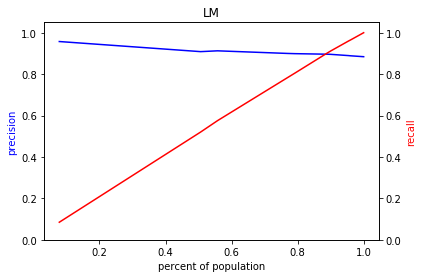

AUC-PR: 0.921761


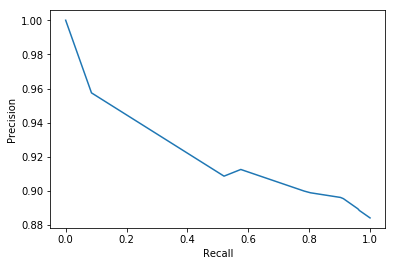


Random Forest Accuracy 0.885833333333


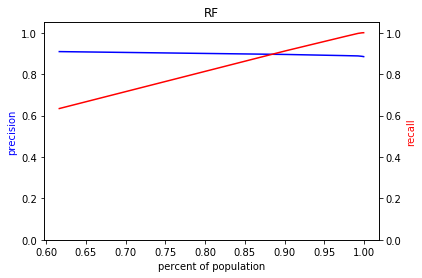

AUC-PR: 0.934257


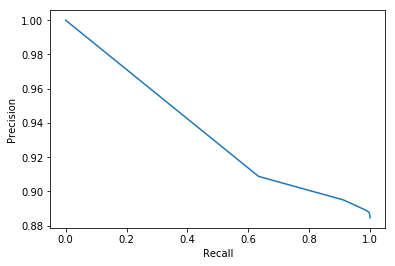

             precision    recall  f1-score   support

Not Helpful       0.83      0.02      0.04       278
    Helpful       0.89      1.00      0.94      2122

avg / total       0.88      0.89      0.83      2400




/Users/shraws/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGD Accuracy 0.844166666667
             precision    recall  f1-score   support

Not Helpful       0.29      0.23      0.26       278
    Helpful       0.90      0.92      0.91      2122

avg / total       0.83      0.84      0.84      2400

Baseline accuracy for test data 0.7460616791590563


In [ ]:
for cat in cats:
    df = read_dataset(cat)
    df.head()
    print("number of revs",len(df))

    df['review_length'] = [len(x.split()) for x in df['review_text']]

    df['text_richness'] = df.review_text.apply(lambda x: text_richness(x))
    print("text richness score calculated")

#     afinn  = Afinn(emoticons=True)
#     df['afinn'] = df.review_text.apply(lambda x: afinn.score(x))
#     sentiment_mean = np.mean(df['afinn'])
#     sentiment_std = np.std(df['afinn'])
#     df['afinn_normal'] = (df['afinn']-sentiment_mean)/sentiment_std
#     print("sentiment score calculated")
    
    image_regex = 'picture[s]?|attach[ed|ment]|image[s]?|video[s]'
    df['image_flag'] = [1 if x else 0 for x in df.review_text.str.contains(image_regex, regex=True, case=0)]

#     df['avg_word_len'] = df.review_text.apply(lambda x: word_length_avg(x))

    score_median = np.median(df['score'])
    print("Median score", score_median)

    score_mean = np.mean(df['score'])
    print("Mean score", score_mean)

    df_good = df[df['score']>=0.5]
    df_bad = df[df['score']<0.5]

    len_bad = len(df_bad)
    len_good = len(df_good)

    print("Not Helpful reviews",len_bad)
    print("Helpful reviews", len_good)
    print("Baseline accuracy",len_good/len(df))

    corpus = df["review_text"]

    #Stop word list
    eng_stopwords =  stopwords.words('english')

    #get rid of the punctuations and set all characters to lowercase
    RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters
    stemmer = PorterStemmer()
    #Retrieve words and lowercase them
    processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )

#     processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
#                                                                      stop_words=eng_stopwords,
#                                                                      stem=True,
#                                                                      NGRAM_RANGE=(0,2),
#                                                                      USE_IDF = True)

    nVec = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), min_df=1)
    processed_bag_of_words = nVec.fit_transform(processed_corpus)
    y= []
    for score in df['score']:
        if score >= 0.5:
            y.append(1)
        else:
            y.append(0)
    
    y_reg = df['score']
    
    target_names = ["Not Helpful", "Helpful"]
    #Adding features
    X = hstack((processed_bag_of_words,np.array(df['overall']/5)[:,None]))
    X = hstack((X,np.array(df['review_length']/np.max(df['review_length']))[:,None]))
    X = hstack((X,np.array(df['image_flag'])[:,None]))
#     X = hstack((X,np.array(df['avg_word_len'])[:,None]))
    #X = hstack((X,np.array(df['afinn_normal'])[:,None]))
    #Logistic
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

    print("Length of training data",len(y_train))
    print("Length of test data", len(y_test))
    y_score
    print("Baseline accuracy", np.mean(y_train))
    
    #Logistic Model
    clf = LogisticRegression(penalty='l1',C=.02)
    mdl = clf.fit(X_train, y_train) #train the classifer to get the model
    
    y_score = mdl.predict_proba(X_test )
    y_pred = mdl.predict(X_test)
    acc1= accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    
    print("Logistic Accuracy", acc1)
    print(classification_report(y_test, y_pred, target_names=target_names))    
    plot_precision_recall_n(y_test,y_score[:,1], 'LM')
    plot_precision_recall(y_test,y_score);
    
#     print_results(y_pred,y_test,X_test)
    print()
    
    #RandomForest Model
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    mdl = clf.fit(X_train, y_train)
    y_score = mdl.predict_proba(X_test )
    y_pred = mdl.predict(X_test)
    acc2= accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    print("Random Forest Accuracy", acc2)
    plot_precision_recall_n(y_test,y_score[:,1], 'RF')
    plot_precision_recall(y_test,y_score);
    print(classification_report(y_test, y_pred, target_names=target_names))
#     print_results(y_pred,y_test,X_test)
    print()
    
    clf = linear_model.SGDClassifier(loss='squared_hinge')
    clf.fit(X_train, y_train)
    mdl = clf.fit(X_train, y_train)
   # y_score = mdl.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    acc3= accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    print("SGD Accuracy", acc3)
    print(classification_report(y_test, y_pred, target_names=target_names))
#     plot_precision_recall_n(y_test,y_score[:,1], 'RF')
#     plot_precision_recall(y_test,y_score);
    
    #regresssion
    X_train,X_test,y_train,y_test = train_test_split(X,y_reg,test_size=0.2, random_state=42)
    baseline_score = np.mean(y_test)
    print("Baseline accuracy for test data", baseline_score)
    
    reg = linear_model.LinearRegression()
    mdl = reg.fit(X_train, y_train)
    y_score= mdl.predict(X_test)
    
    print("baseline mse",mean_squared_error(y_test, [baseline_score]*len(y_test)))
    
    print("mse", mean_squared_error(y_score, [baseline_score]*len(y_test)))
    print("\n\n")
#     for i in range(len(y_test)):
#         if math.fabs(y_test[i]-y_score) <0.02 and y_score<0.5:
#             print()
#     print('Accuracy of different classifier, with Normalization')
#     normalization_methods_name = ['StandardScaler', 'Normalizer']#, 'RobustScaler'
#     normalization_methods = [StandardScaler(), Normalizer()]#, RobustScaler(),
#     # iterate over classifiers
#     for name, clf in zip(clf_names, classifiers):
#         print('\n')
#         for norm_name, norm in zip(normalization_methods_name, normalization_methods):
#             loo = cross_validation.KFold(5)
#             scores = cross_validation.cross_val_score(make_pipeline(clf), X, y_reg, scoring='neg_mean_squared_error', cv=loo)
#             clf.fit(X,y_reg)
#             print('{},{},mean_squared_error:{}'.format(name, norm_name,mean_squared_error(y_reg, clf.predict(X))))
            
            
            

In [104]:
y_score = [[0.3,0.7]]*10

In [109]:
y_score[:5]

[[0.3, 0.7], [0.3, 0.7], [0.3, 0.7], [0.3, 0.7], [0.3, 0.7]]

In [110]:
y_test[:4]

1935    0.9
6494    1.0
1720    1.0
9120    1.0
Name: score, dtype: float64

In [113]:
np.asarray([score_mean]*len(y_test),)

array([ 0.74732032,  0.74732032,  0.74732032, ...,  0.74732032,
        0.74732032,  0.74732032])